# 5 Modelling - Task 5

## Import and Initializing

In [1]:
import numpy as np
import pandas as pd

from sklearn import linear_model, metrics, preprocessing, pipeline  # pip3 install sklearn --user
from scipy import optimize

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")

FIGSIZE = (16,4)

In [2]:
dataset = pd.read_excel("../datasets/DB01_gaming_video_quality_dataset.xlsx")

# calculate MOS
mos_by_game_condition = dataset.groupby(["Game", "Condition"]).mean()

#calculate bit per pixel
num_pixels = {
    480: 720 * 480,
    720: 1280 * 720,
    1080: 1920 * 1080
}

def count_pixels(resolution):
    return num_pixels[int(resolution)]

mos_by_game_condition["num_pixels"] = mos_by_game_condition.Resolution.transform(count_pixels)
mos_by_game_condition["bitperpixel"] = mos_by_game_condition.Bitrate / mos_by_game_condition.num_pixels

## Predicting VF, VD and VU

In [3]:
def perform_polynomial_prediction(to_predict, based_on ="bitperpixel", subplot_position=0):
    X = mos_by_game_condition[[based_on]].values
    y = mos_by_game_condition[[to_predict]].values

    model = pipeline.make_pipeline(
        preprocessing.PolynomialFeatures(degree=3), linear_model.LinearRegression()
    )
    model.fit(X, y)

    X_predict = np.linspace(np.min(X), np.max(X), num=144).reshape(-1, 1)
    y_predict = model.predict(X_predict)

    ax[subplot_position].scatter(X, y, label="Training data")
    ax[subplot_position].plot(X_predict, y_predict, c="C1", label="Prediction")
    if based_on == "bitperpixel": based_on = "Bits per pixel"
    ax[subplot_position].set_xlabel(based_on)
    ax[subplot_position].set_ylabel(f"Mean {to_predict}")
    ax[subplot_position].legend()
    return ax[subplot_position], (X_predict, y_predict)

Polynomial regression (3rd degree): 


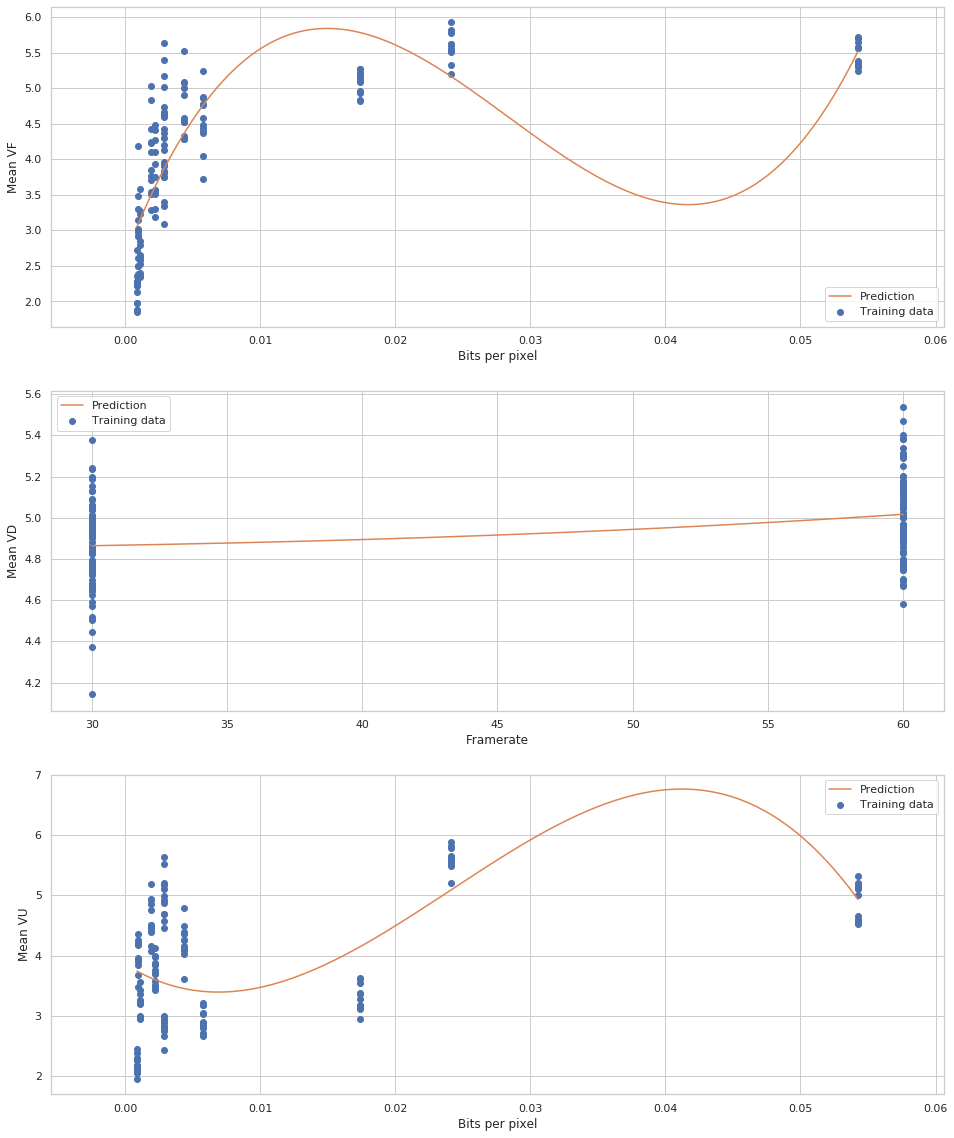

In [4]:
# Task 5.1

fig, ax = plt.subplots(3, figsize=(16,20))
ax[0], (vf_pred_x, vf_pred_y) = perform_polynomial_prediction("VF")
ax[1], (vd_pred_x, vd_pred_y) = perform_polynomial_prediction("VD", "Framerate", 1)
ax[2], (vu_pred_x, vu_pred_y) = perform_polynomial_prediction("VU", subplot_position=2)

print("Polynomial regression (3rd degree): ")

## Predict video quality

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until


RMSE = 0.937569542311686, RMSE from real VQ = 0.0
R^2 = 0.04682707128407815, R^2 from real VQ = 1.0


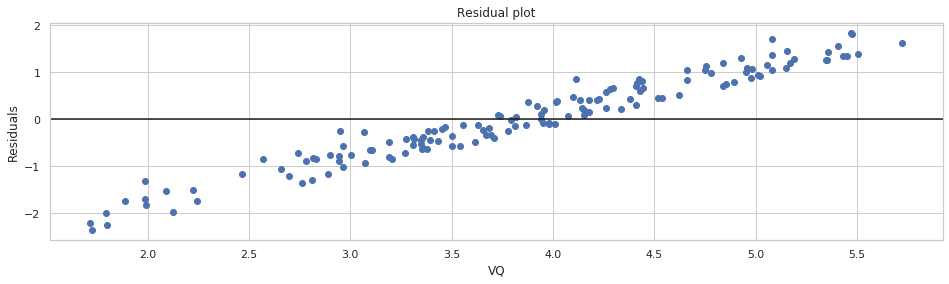

In [5]:
# Task 5.2

X = list(zip(map(np.asscalar, vf_pred_y), map(np.asscalar, vu_pred_y), map(np.asscalar, vd_pred_y)))
y = mos_by_game_condition[["VQ"]].values

model = linear_model.LinearRegression()
model.fit(X, y)

vq_prediction = model.predict(X)
residuals = y - vq_prediction

# Residual plot

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.scatter(y, residuals)

padding = 0.2
min_x = y.min() - padding
max_x = y.max() + padding
ax.hlines(0, min_x, max_x)
ax.set_xlim([min_x, max_x])

ax.set_title("Residual plot")
ax.set_ylabel("Residuals")
ax.set_xlabel("VQ")

# Report results
real_vq = mos_by_game_condition[["VQ"]].values

MSE = (residuals ** 2).mean()
RMSE = np.sqrt(MSE)

MSE_real = ((y-real_vq) ** 2).mean()
RMSE_real = np.sqrt(MSE_real)
print(f"RMSE = {RMSE}, RMSE from real VQ = {RMSE_real}")

r_squared = metrics.r2_score(y, vq_prediction)
r_squared_real = metrics.r2_score(y, real_vq)
print(f"R^2 = {r_squared}, R^2 from real VQ = {r_squared_real}")